# Feedfoward Neural Networks & Training on GPU



## Data

In [1]:
import torch
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [2]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

In [3]:
len(dataset)

60000

label: 5
torch.Size([1, 28, 28])


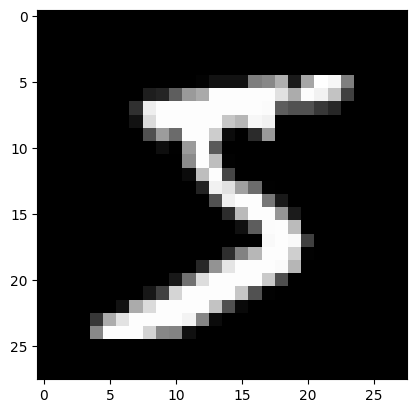

In [4]:
img, label = dataset[0]
print('label:', label)
print(img.shape)
import matplotlib.pyplot as plt
plt.imshow(img.squeeze(), cmap='gray')


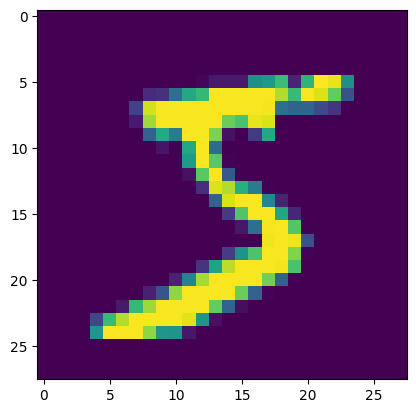

In [5]:

img_permuted = img.permute(1, 2, 0)
plt.imshow(img_permuted)

In [6]:
def split_indices(n, val_pct):
    # Determine size of validation set
    n_val = int(val_pct*n)
    # Create random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [7]:
batch_size=100
train_indices, val_indices = split_indices(len(dataset), val_pct=0.2)

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                      batch_size,
                      sampler=train_sampler)

# Validation sampler and data loader
valid_sampler = SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset,
                    batch_size,
                    sampler=valid_sampler)

images.shape: torch.Size([100, 1, 28, 28])


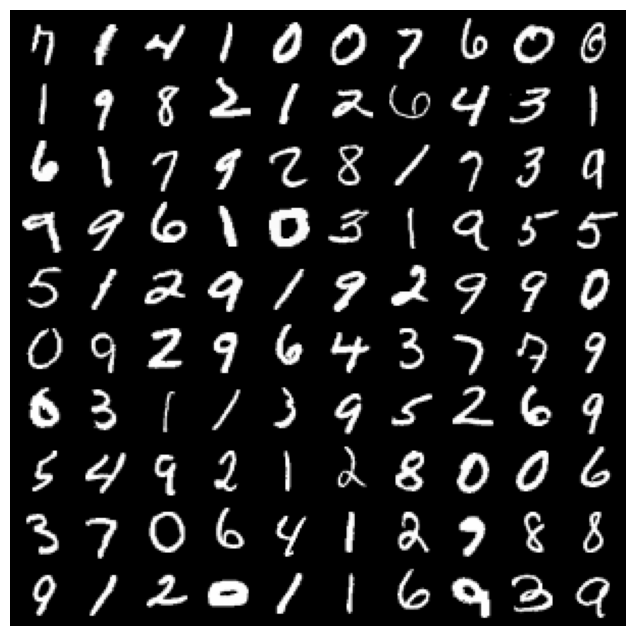

In [8]:
from torchvision.utils import make_grid

for images, labels in train_dl:
    print('images.shape:', images.shape)

    plt.figure(figsize=(16, 8))
    plt.imshow(make_grid(images, nrow=10).permute(1, 2, 0))
    plt.axis('off')

    break


## Using a GPU

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [10]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [11]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [12]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model

In [13]:
import torch.nn.functional as F
import torch.nn as nn

In [14]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out

In [15]:
input_size = 784
num_classes = 10

model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [16]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [19]:
for images, labels in train_dl:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

RuntimeError: Expected all tensors to be on the same device, but got mat1 is on cuda:0, different from other tensors on cpu (when checking argument in method wrapper_CUDA_addmm)

In [20]:
# if you get the error of Expected all tensors to be on the same device,...run this

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#move the model
model = model.to(device)
# move each batch inside the loop
import torch.nn.functional as F

for images, labels in train_dl:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape:', outputs.shape)
print('Sample outputs:\n', outputs[:2].data)


Loss: 2.3089652061462402
outputs.shape: torch.Size([100, 10])
Sample outputs:
 tensor([[-0.0396, -0.1019,  0.1637, -0.2324, -0.0478,  0.1440, -0.1513, -0.2065,
         -0.1923,  0.2194],
        [ 0.0446, -0.1683,  0.1245, -0.1959, -0.0558,  0.0822, -0.2310, -0.0494,
         -0.1812,  0.0242]], device='cuda:0')


## Training the Model

In [24]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    # Generate predictions
    preds = model(xb)
    # Calculate loss
    loss = loss_func(preds, yb)

    if opt is not None:
        # Compute gradients
        loss.backward()
        # Update parameters
        opt.step()
        # Reset gradients
        opt.zero_grad()

    metric_result = None
    if metric is not None:
        # Compute the metric
        metric_result = metric(preds, yb)

    return loss.item(), len(xb), metric_result

In [25]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        # Pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric)
                   for xb,yb in valid_dl]
        # Separate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        # Total size of the dataset
        total = np.sum(nums)
        # Avg. loss across batches
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        if metric is not None:
            # Avg. of metric across batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric

In [26]:
def fit(epochs, lr, model, loss_fn, train_dl, valid_dl, metric=None, opt_fn=None):
    # Optimizer
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = torch.optim.SGD(model.parameters(), lr=lr)

    #

    for epoch in range(epochs):
        # Training
        for xb,yb in train_dl:
            loss,_,_ = loss_batch(model, loss_fn, xb, yb, opt)

        # Evaluation
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result

        # Print progress
        if metric is None:
            print('Epoch [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, epochs, val_loss))
        else:
            print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'
                  .format(epoch+1, epochs, val_loss, metric.__name__, val_metric))

In [27]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [28]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [29]:
evaluate(model, F.cross_entropy, valid_dl, accuracy)

(np.float64(2.3202133258183797), np.int64(12000), np.float64(0.092))

In [ ]:
fit(5, 0.5, model, F.cross_entropy, train_dl, valid_dl, accuracy)

Epoch [1/5], Loss: 0.2126, accuracy: 0.9377
Epoch [2/5], Loss: 0.2069, accuracy: 0.9380
Epoch [3/5], Loss: 0.1663, accuracy: 0.9502
Epoch [4/5], Loss: 0.1443, accuracy: 0.9557
Epoch [5/5], Loss: 0.1440, accuracy: 0.9571


In [30]:
fit(5, 0.5, model, F.cross_entropy, train_dl, valid_dl, accuracy)

Epoch [1/5], Loss: 0.2232, accuracy: 0.9350
Epoch [2/5], Loss: 0.2046, accuracy: 0.9347
Epoch [3/5], Loss: 0.1496, accuracy: 0.9577
Epoch [4/5], Loss: 0.1443, accuracy: 0.9598
Epoch [5/5], Loss: 0.1430, accuracy: 0.9588


In [31]:
import matplotlib.pyplot as plt

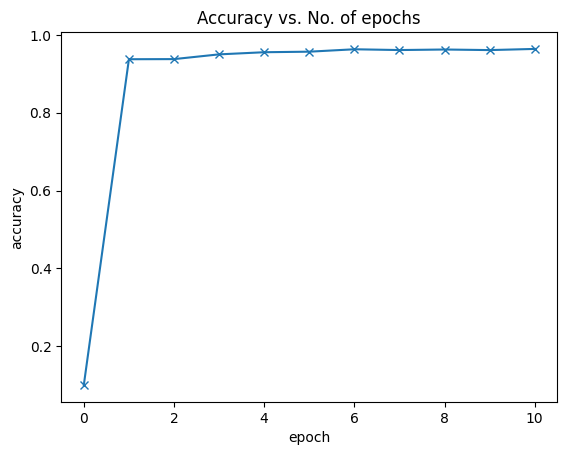

In [32]:
# Replace these values with your results
accuracies = [0.1, 0.9377, 0.9380, 0.9502, 0.9557, 0.9571,
              0.9633, 0.9613, 0.9627, 0.9612, 0.9642]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

## Save and upload

In [33]:
torch.save(model.state_dict(), 'mnist-feedforward.pth')